#1 Feature engineering
>Here, you are going to create features from a very simple dataset: retail transaction data from Kaggle. The dataset provides the customer ID, date of the transaction and transaction amount as shown in the table below. Although this may look like a very simple dataset, you will build a wide range of features. The features will then be used as inputs in several models in upcoming assignments, in which you will try to predict the client's response to a promotion campaign.

## 1.1 Import the data and create the anchor date columns
>In order to create features, you need to create some anchor dates. The most typical for transaction data is the end of the month and the year.
1. Import the dataset as txn and identify the number of rows.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [2]:
txn = pd.read_csv('Retail_Data_Transactions.csv')
print(f'number of rows:',txn.shape[0])

number of rows: 125000


>2. The date-format in column 'trans date' is not standard. Create a new column 'txn_date' from 'trans_date' with pd.to_datetime and drop the column 'trans_date'.

In [3]:
txn['txn_date'] = pd.to_datetime(txn['trans_date']) 
txn = txn.drop(['trans_date'],axis=1)
txn.head()

,customer_id,tran_amount,txn_date
0,CS5295,35,2013-02-11
1,CS4768,39,2015-03-15
2,CS2122,52,2013-02-26
3,CS1217,99,2011-11-16
4,CS1850,78,2013-11-20


>3. Identify the min() and max() of column 'txn_date'.

In [4]:
print(f'min date:',min(txn['txn_date']))
print(f'max date:',max(txn['txn_date']))

min date: 2011-05-16 00:00:00
max date: 2015-03-16 00:00:00


>4. Create the column 'ME_DT': the last day of the month in the 'trans_date' column. DateOffset objects is a simple way to do this in pandas.

In [5]:
txn['ME_DT'] = txn['txn_date'] + pd.offsets.MonthEnd(n=0)
txn.head()

,customer_id,tran_amount,txn_date,ME_DT
0,CS5295,35,2013-02-11,2013-02-28
1,CS4768,39,2015-03-15,2015-03-31
2,CS2122,52,2013-02-26,2013-02-28
3,CS1217,99,2011-11-16,2011-11-30
4,CS1850,78,2013-11-20,2013-11-30


>5. Create the column 'YEAR': the year in the 'trans_date' column. DatetimeIndex with
attribute .year will help you do so.

In [6]:
txn['YEAR'] = pd.DatetimeIndex(txn['txn_date']).year
txn.iloc[55:60]

,customer_id,tran_amount,txn_date,ME_DT,YEAR
55,CS2662,88,2014-08-31,2014-08-31,2014
56,CS2209,35,2012-03-12,2012-03-31,2012
57,CS4530,40,2011-06-05,2011-06-30,2011
58,CS2848,53,2013-02-04,2013-02-28,2013
59,CS2596,55,2011-09-19,2011-09-30,2011


##1.2 Create features that capture annual spending
>Here the approach is to capture the client's annual spending. The rationale behind this approach is that the clients spend is not very frequent to capture in a monthly aggregation.
1. Using groupby and NamedAgg create **clnt_annual_aggregations**, the annual aggregations dataframe: with sum, mean, std, var, sem, max, min, count as the aggregation functions. A snapshot of the output table is shown below. Notice that the output is a typical MultiIndex pandas dataframe.

In [7]:
clnt_annual_aggregations = txn.groupby(["customer_id",'YEAR']).agg(
    ann_txn_amt_sum = pd.NamedAgg('tran_amount','sum'),
    ann_txn_amt_ave = pd.NamedAgg('tran_amount','mean'),
    ann_txn_amt_std = pd.NamedAgg('tran_amount','std'),
    ann_txn_amt_var = pd.NamedAgg('tran_amount','var'),
    ann_txn_amt_sem = pd.NamedAgg('tran_amount','sem'),
    ann_txn_amt_max = pd.NamedAgg('tran_amount','max'),
    ann_txn_amt_min = pd.NamedAgg('tran_amount','min'),
    ann_txn_amt_cnt = pd.NamedAgg('tran_amount','count')    
)
clnt_annual_aggregations.head()

ann_txn_amt_sum  ...  ann_txn_amt_cnt
customer_id YEAR                   ...                 
CS1112      2011              212  ...                3
            2012              337  ...                5
            2013              212  ...                3
            2014              212  ...                3
            2015               39  ...                1

[5 rows x 8 columns]

>2. Plot the histogram of the sum and count.

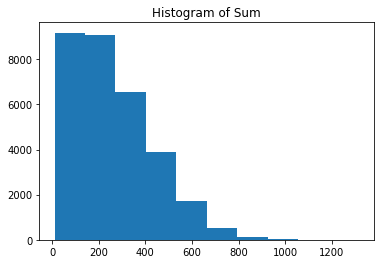

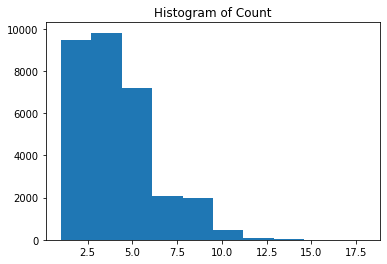

In [8]:
#plot sum
plt.hist(clnt_annual_aggregations['ann_txn_amt_sum'])
plt.title("Histogram of Sum")
plt.show()

#plot count
plt.hist(clnt_annual_aggregations['ann_txn_amt_cnt'])
plt.title("Histogram of Count")
plt.show()

>3. Reset the index and reshape the table with the pivot table function to create the **clnt_annual_aggregations_pivot** table shown below with 40 columns (why 40?).

Beacuse there are 8 aggregated features. For each feature, there are 5 years data. So there are 8 * 5 = 40 columes.

>You should expect columns with NaN values. Impute the NaN entries when you perform the pivot table function and explain your choice of values.

I fill NANs with 0s. Because if the data is missing indicates that the customer didn't have any transactions.

In [9]:
clnt_annual_aggregations_pivot = clnt_annual_aggregations.pivot_table(columns='YEAR',index='customer_id').fillna(0)
clnt_annual_aggregations_pivot.head()

ann_txn_amt_ave             ... ann_txn_amt_var            
YEAR                   2011       2012  ...            2014        2015
customer_id                             ...                            
CS1112            70.666667  67.400000  ...      284.333333    0.000000
CS1113            81.333333  74.800000  ...      781.666667  745.333333
CS1114            85.200000  75.000000  ...      726.166667    0.000000
CS1115            87.000000  67.571429  ...      512.250000    0.000000
CS1116            58.750000  76.666667  ...      636.800000    0.000000

[5 rows x 40 columns]

>4. The pivoted object you created is a MultiIndex object with hierarchical indexes. You can see the first level (i.e. 0) in the snapshot above with names 'ann_txn_amt_ave', 'ann_txn_amt_max' (and more as indicated by the ...) and the second level (i.e. 1)
with names '2011', '2012', etc. You can confirm the multiple levels of the columns with the following two expressions.

>What are your observations regarding the number of levels and the column names?

There are two levels, the column name is (level0, level1).

In [10]:
print(clnt_annual_aggregations_pivot.columns.nlevels)
print(clnt_annual_aggregations_pivot.columns)

2
MultiIndex([('ann_txn_amt_ave', 2011),
            ('ann_txn_amt_ave', 2012),
            ('ann_txn_amt_ave', 2013),
            ('ann_txn_amt_ave', 2014),
            ('ann_txn_amt_ave', 2015),
            ('ann_txn_amt_cnt', 2011),
            ('ann_txn_amt_cnt', 2012),
            ('ann_txn_amt_cnt', 2013),
            ('ann_txn_amt_cnt', 2014),
            ('ann_txn_amt_cnt', 2015),
            ('ann_txn_amt_max', 2011),
            ('ann_txn_amt_max', 2012),
            ('ann_txn_amt_max', 2013),
            ('ann_txn_amt_max', 2014),
            ('ann_txn_amt_max', 2015),
            ('ann_txn_amt_min', 2011),
            ('ann_txn_amt_min', 2012),
            ('ann_txn_amt_min', 2013),
            ('ann_txn_amt_min', 2014),
            ('ann_txn_amt_min', 2015),
            ('ann_txn_amt_sem', 2011),
            ('ann_txn_amt_sem', 2012),
            ('ann_txn_amt_sem', 2013),
            ('ann_txn_amt_sem', 2014),
            ('ann_txn_amt_sem', 2015),
            ('ann_txn_a

>5. Finally, you want to save the dataframe **clnt_annual_aggregations_pivot** as an .xlsx file for future use in the machine learning assignment. To do so, you want to remove the two levels in columns and create a single level with column names: 'ann txn_amt_ave_2011', 'ann_txn_amt_ave_2012', etc. To do so, use the code snippet below prior to saving the dataframe as an Excel file.

>Describe what each line of code in the box does and save the output dataframe as an Excel file annual features.xlsx. A snapshot of the desired final output is shown
below.

The first two lines extract the name of level 0 and level 1 and convert them to string. Named them level_0 and level_1. The third line concatenates level 0, '_', and level 1 to get the new column name.

In [11]:
#extract the name of level 0 and level 1 and convert them to string. Named them level_0 and level_1.
level_0 = clnt_annual_aggregations_pivot.columns.get_level_values(0).astype(str)
level_1 = clnt_annual_aggregations_pivot.columns.get_level_values(1).astype(str)
#concatenate level 0 and level 1 to get the new column name
clnt_annual_aggregations_pivot.columns = level_0 + '_' + level_1
clnt_annual_aggregations_pivot.head()

,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,ann_txn_amt_cnt_2015,ann_txn_amt_max_2011,ann_txn_amt_max_2012,ann_txn_amt_max_2013,ann_txn_amt_max_2014,ann_txn_amt_max_2015,ann_txn_amt_min_2011,ann_txn_amt_min_2012,ann_txn_amt_min_2013,ann_txn_amt_min_2014,ann_txn_amt_min_2015,ann_txn_amt_sem_2011,ann_txn_amt_sem_2012,ann_txn_amt_sem_2013,ann_txn_amt_sem_2014,ann_txn_amt_sem_2015,ann_txn_amt_std_2011,ann_txn_amt_std_2012,ann_txn_amt_std_2013,ann_txn_amt_std_2014,ann_txn_amt_std_2015,ann_txn_amt_sum_2011,ann_txn_amt_sum_2012,ann_txn_amt_sum_2013,ann_txn_amt_sum_2014,ann_txn_amt_sum_2015,ann_txn_amt_var_2011,ann_txn_amt_var_2012,ann_txn_amt_var_2013,ann_txn_amt_var_2014,ann_txn_amt_var_2015
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,70.666667,67.400000,70.666667,70.666667,39.000000,3.0,5.0,3.0,3.0,1.0,96.0,81.0,105.0,90.0,39.0,56.0,52.0,36.0,59.0,39.0,12.719189,5.688585,19.919282,9.735388,0.000000,22.030282,12.720063,34.501208,16.862186,0.000000,212.0,337.0,212.0,212.0,39.0,485.333333,161.800000,1190.333333,284.333333,0.000000
CS1113,81.333333,74.800000,85.200000,56.500000,73.333333,3.0,5.0,5.0,4.0,3.0,94.0,95.0,97.0,97.0,98.0,57.0,51.0,65.0,36.0,44.0,12.170091,7.618399,5.851496,13.979151,15.762121,21.079216,17.035258,13.084342,27.958302,27.300794,244.0,374.0,426.0,226.0,220.0,444.333333,290.200000,171.200000,781.666667,745.333333
CS1114,85.200000,75.000000,70.400000,70.833333,79.000000,5.0,2.0,5.0,6.0,1.0,97.0,97.0,105.0,95.0,79.0,76.0,53.0,43.0,37.0,79.0,4.352011,22.000000,11.129241,11.001263,0.000000,9.731393,31.112698,24.885739,26.947480,0.000000,426.0,150.0,352.0,425.0,79.0,94.700000,968.000000,619.300000,726.166667,0.000000
CS1115,87.000000,67.571429,79.571429,78.250000,55.000000,3.0,7.0,7.0,4.0,1.0,102.0,104.0,94.0,98.0,55.0,72.0,41.0,66.0,50.0,55.0,8.660254,8.257341,3.981249,11.316470,0.000000,15.000000,21.846870,10.533394,22.632941,0.000000,261.0,473.0,557.0,313.0,55.0,225.000000,477.285714,110.952381,512.250000,0.000000
CS1116,58.750000,76.666667,59.000000,66.600000,0.000000,4.0,3.0,1.0,5.0,0.0,87.0,105.0,59.0,96.0,0.0,41.0,45.0,59.0,40.0,0.0,10.601690,17.400511,0.000000,11.285389,0.000000,21.203380,30.138569,0.000000,25.234896,0.000000,235.0,230.0,59.0,333.0,0.0,449.583333,908.333333,0.000000,636.800000,0.000000


In [12]:
#save the output dataframe as an Excel file annual_features.xlsx
clnt_annual_aggregations_pivot.to_excel("annual_features.xlsx")

6. What are the possible disadvantages in capturing client transaction behavior with the
annual features described in this section (if any)?

I think that annual data is too general. To better find patterns of selling, the data can be more detailed like using weekly or monthly data.

##1.3 Create monthly aggregations
>Here, you want to explore the monthly sum of amounts and count of clients transactions.
1. Create the dataframe that captures the monthly sum and count of transactions per client (name
it **clnt_monthly_aggregations**). Use the groupby function with the Named Aggregation feature which was introduced in pandas version 0.25.0. Make sure that you name the columns
as shown in the  gure sample on the right.

In [13]:
clnt_monthly_aggregations = txn.groupby(["customer_id",'ME_DT']).agg(
    mth_txn_amt_sum = pd.NamedAgg('tran_amount','sum'),
    mth_txn_cnt = pd.NamedAgg('tran_amount','count')    
)
clnt_monthly_aggregations.head()

mth_txn_amt_sum  mth_txn_cnt
customer_id ME_DT                                   
CS1112      2011-06-30               56            1
            2011-08-31               96            1
            2011-10-31               60            1
            2012-04-30               56            1
            2012-06-30               52            1

>2. Create a histogram of both columns you created. What are your observations? What are the most common and maximum values for each column? How do they compare with the ones in section 1.2?

The majority of customer has only one transaction per month. Compared with the annual figure, we can find that both figures are skewed right distributed. Monthly graphs had a smaller x-axis scale. 

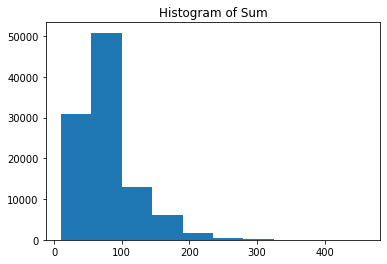

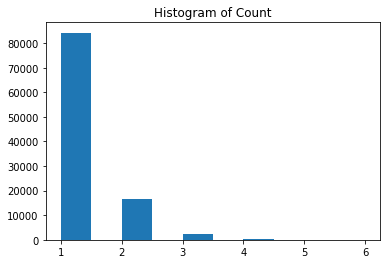

Most Common Value for sum: 77
Maximum Value for sum: 460
Most Common Value for count: 1
Maximum Value for count: 6


In [14]:
#plot sum
plt.hist(clnt_monthly_aggregations['mth_txn_amt_sum'])
plt.title("Histogram of Sum")
plt.show()

#plot count
plt.hist(clnt_monthly_aggregations['mth_txn_cnt'])
plt.title("Histogram of Count")
plt.show()

print('Most Common Value for sum:',clnt_monthly_aggregations['mth_txn_amt_sum'].mode()[0])
print('Maximum Value for sum:',clnt_monthly_aggregations['mth_txn_amt_sum'].max())
print('Most Common Value for count:',clnt_monthly_aggregations['mth_txn_cnt'].mode()[0])
print('Maximum Value for count:',clnt_monthly_aggregations['mth_txn_cnt'].max())

##1.4 Create the base table for the rolling window features
>1. Create the numpy array of the unique elements in columns 'customer id' and 'ME DT' of the txn table you created in section 1.1. Confirm that you have 6,889 unique clients and 47 unique month-end-dates.

In [15]:
clnt_no = txn['customer_id'].unique()
me_dt = txn['ME_DT'].unique()
print("number of unique clients:", len(clnt_no))
print("number of unique month-end-dates:", len(me_dt))

number of unique clients: 6889
number of unique month-end-dates: 47


>2. Use itertools.product to generate all the possible combinations of 'customer_id' and
'ME_DT'. Itertools is a Python module that iterates over data in a computationally effcient way. You can perform the same task with a for-loop, but the execution may be inefficient. For a brief overview of the Itertools module see here. If you
named the numpy arrays with the unique elements: **clnt_no** and **me_dt**, then the code below will create an itertools.product object (you can con rm this by running:
type(base table)).

In [16]:
base_table = product (clnt_no, me_dt)

3. Next, you want to convert the itertools.product object base table into a pandas object called **base_table_pd**. To do so, use pd.DataFrame.from records and name the columns 'CLNT_NO' and 'ME_DT'.

In [17]:
base_table_pd = pd.DataFrame.from_records(base_table)
base_table_pd.columns = ['CLNT_NO', 'ME_DT']

>4. Finally, you want to validate that you created the table you originally wanted. There are two checks you want to perform:
* Filter client CS1112 and confirm that the dates fall between the min and max month-dates you identified in section 1.1. Also, confirm that the snapshot of client CS1112 has 47 rows, one for each month in the dataset.

From 1.1, we have min date: 2011-05-16 00:00:00, max date: 2015-03-16 00:00:00. Dates of client CS1112 fall between the min and max month-dates.

In [18]:
cs1112 = base_table_pd[base_table_pd['CLNT_NO'] == 'CS1112']
print('min month-dates of CS1112:', min(cs1112['ME_DT']))
print('max month-dates of CS1112:', max(cs1112['ME_DT']))
print(f'CS1112 has {len(cs1112)} rows')

min month-dates of CS1112: 2011-05-31 00:00:00
max month-dates of CS1112: 2015-03-31 00:00:00
CS1112 has 47 rows


>* Confirm that the **base_table_pd** has 323,783 rows, which is the expected value of combinations for 6,889 unique clients and 47 unique month-end dates.

In [19]:
print(f'base_table_pd has {base_table_pd.shape[0]} rows.')

base_table_pd has 323783 rows.


##1.5 Create the monthly rolling window features
>1. Left-join the **base_table_pd** with the **clnt_monthly_aggregations** table from section 1.3 on [CLNT_NO, ME_DT] to create the table **base_clnt_mth**.

In [20]:
clnt_monthly_aggregations.index.set_names(['CLNT_NO','ME_DT'],inplace=True)
base_clnt_mth = base_table_pd.merge(clnt_monthly_aggregations, on = ['CLNT_NO', 'ME_DT'], how = 'left')
base_clnt_mth.head()

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS5295,2013-02-28,35.0,1.0
1,CS5295,2015-03-31,NaN,NaN
2,CS5295,2011-11-30,132.0,2.0
3,CS5295,2013-11-30,NaN,NaN
4,CS5295,2014-03-31,NaN,NaN


>Comment on the following questions in Markdown:
* Why do some rows have NaN values?

The base_table_pd has 323783 rows, while the right table clnt_monthly_aggregations only has 103234 rows. Because clnt_monthly_aggregations table doesn't have records matched in the base_table_pd, some rows will have NaN values.

>* What values will you choose to impute NaN values in the sum and count columns? Perform the imputation you suggest.

I will fill NaN values with 0s since it indicates that the customer had no transaction at that month.

In [21]:
base_clnt_mth.fillna(0, inplace = True)
base_clnt_mth.head()

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt
0,CS5295,2013-02-28,35.0,1.0
1,CS5295,2015-03-31,0.0,0.0
2,CS5295,2011-11-30,132.0,2.0
3,CS5295,2013-11-30,0.0,0.0
4,CS5295,2014-03-31,0.0,0.0


>* Confirm that the number of rows is what you expect. What is the value?

The number of rows I expected is 323783 which matches the number of rows in the base_table_pd.


In [22]:
print(f'base_clnt_mth has {len(base_clnt_mth)} rows.')

base_clnt_mth has 323783 rows.


>* How are tables **base_clnt_mth** and **clnt_monthly_aggregations** different? Comment on the number of rows and the content of each table.

clnt_monthly_aggregations has 103234 rows, it only contains the record of customers' transactions.
base_clnt_mth has 323783 rows, including all the combinations of customers and months. It contains all records for both transaction and non-transaction.

>2. For the next step, the calculation of the rolling window features, you need to sort the
data first by 'CLNT_NO' and then by 'ME_DT' in ascending order. This is necessary to create the order for rolling windows, e.g. 2011-05-31, 2011-06-30, etc.

In [23]:
base_clnt_mth = base_clnt_mth.sort_values(['CLNT_NO','ME_DT'],ascending = True)
base_clnt_mth.head()

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt
157064,CS1112,2011-05-31,0.0,0.0
157058,CS1112,2011-06-30,56.0,1.0
157044,CS1112,2011-07-31,0.0,0.0
157069,CS1112,2011-08-31,96.0,1.0
157060,CS1112,2011-09-30,0.0,0.0


> 3.Here, you have to calculate separately the 3, 6 and 12-month rolling window features
(tables: **rolling_features_3M**, **rolling_features_6M**, **rolling_features_12M**) for every client that calculates the aggregations 'sum', mean' and 'max' for both columns
'mth_txn_amt_sum' and 'mth_txn_cnt'. The steps to achieve this with **base_clnt_mth** as the starting dataframe are:
>* groupby the client number
>* select the two columns you want to aggregate
>* use the rolling function with the appropriate windows
>* aggregate with 'sum', 'mean' and 'max'

In [24]:
#calculate the 3, 6 and 12-month rolling window features
rolling_features_3M = base_clnt_mth.groupby(['CLNT_NO'])[['mth_txn_amt_sum','mth_txn_cnt']].rolling(3).agg(['sum', 'mean', 'max'])
rolling_features_6M = base_clnt_mth.groupby(['CLNT_NO'])[['mth_txn_amt_sum','mth_txn_cnt']].rolling(6).agg(['sum', 'mean', 'max'])
rolling_features_12M = base_clnt_mth.groupby(['CLNT_NO'])[['mth_txn_amt_sum','mth_txn_cnt']].rolling(12).agg(['sum', 'mean', 'max'])
rolling_features_3M.head()

mth_txn_amt_sum                  mth_txn_cnt               
                           sum       mean   max         sum      mean  max
CLNT_NO                                                                   
CS1112  157064             NaN        NaN   NaN         NaN       NaN  NaN
        157058             NaN        NaN   NaN         NaN       NaN  NaN
        157044            56.0  18.666667  56.0         1.0  0.333333  1.0
        157069           152.0  50.666667  96.0         2.0  0.666667  1.0
        157060            96.0  32.000000  96.0         1.0  0.333333  1.0

>Also, answer the following questions in the .ipynb notebook as Markdown comments.
>* How many rows appear with NaN values at the beginning of each client for 3, 6 and 12-month windows, respectively? Why do they appear?

2, 5, 11 rows respectively. Because the rolling window function computes n rows which makes top n-1 rows don't have enough data to calculate the numbers.

>* How many levels do the index and columns have? Are these MultiIndex dataframes?

Both index and columns have 2 levels, so they are MultiIndex dataframe.

In [25]:
print ("Index levels:",rolling_features_3M.index.nlevels)
print ("Columns levels:",rolling_features_3M.columns.nlevels)

Index levels: 2
Columns levels: 2


>* Rename the columns as following: 'amt_sum_3M', 'amt_mean_3M', 'amt_max_3M',
'txn_cnt_sum_3M', 'txn_cnt_mean_3M', 'txn_cnt_max_3M' and follow the same naming convention for 6M and 12M.

In [26]:
rolling_features_3M.columns = ['amt_sum_3M', 'amt_mean_3M', 'amt_max_3M', 'txn_cnt_sum_3M', 'txn_cnt_mean_3M', 'txn_cnt_max_3M']
rolling_features_6M.columns = ['amt_sum_6M', 'amt_mean_6M', 'amt_max_6M', 'txn_cnt_sum_6M', 'txn_cnt_mean_6M', 'txn_cnt_max_6M']
rolling_features_12M.columns = ['amt_sum_12M', 'amt_mean_12M', 'amt_max_12M', 'txn_cnt_sum_12M', 'txn_cnt_mean_12M', 'txn_cnt_max_12M']

> 4. Merge the 4 tables: **base_clnt_mth**, **rolling_features_3M**, **rolling_features_6M**, **rolling_features_12M** in the output **all_rolling_features**. It is recommended to drop the level:0 of the rolling features MultiIndex table and join with **base_clnt_mth**
on the indexes.

> Make sure you understand why joining on the indexes preserves the CLNT_NO and ME_DT for each index.

In [28]:
rolling_features_3M.index = rolling_features_3M.index.droplevel(0)
rolling_features_6M.index = rolling_features_6M.index.droplevel(0)
rolling_features_12M.index = rolling_features_12M.index.droplevel(0)
all_rolling_features = base_clnt_mth.join(rolling_features_3M).join(rolling_features_6M).join(rolling_features_12M)
all_rolling_features.head()

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
157064,CS1112,2011-05-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157058,CS1112,2011-06-30,56.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157044,CS1112,2011-07-31,0.0,0.0,56.0,18.666667,56.0,1.0,0.333333,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157069,CS1112,2011-08-31,96.0,1.0,152.0,50.666667,96.0,2.0,0.666667,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157060,CS1112,2011-09-30,0.0,0.0,96.0,32.000000,96.0,1.0,0.333333,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> 5. Confirm that your final output **all_rolling_features** has 323,783 rows and 22 columns and save it as **mth_rolling_features.xlsx**.

In [29]:
print(f"all_rolling_features has {all_rolling_features.shape[0]} rows.")
print(f"all_rolling_features has {all_rolling_features.shape[1]} columns.")
all_rolling_features.to_excel("mth_rolling_features.xlsx")

all_rolling_features has 323783 rows.
all_rolling_features has 22 columns.


## 1.6 Date-related features: date of the week
> In this section, you will create the date-related features that capture information about the
day of the week the transactions were performed.
> 1. The DatetimeIndex object you used earlier allows you to extract many components of a DateTime object. Here, you want to use the attributes **dt.dayofweek** and/or **dt.day_name()** to extract the day of the week from column 'txn_date' of the txn table (with Monday=0, Sunday=6). The expected output below shows both columns.

In [32]:
txn['day_of_the_week'] = txn['txn_date'].dt.dayofweek
txn['day_name'] = txn['txn_date'].dt.day_name()
txn.head()

,customer_id,tran_amount,txn_date,ME_DT,YEAR,day_of_the_week,day_name
0,CS5295,35,2013-02-11,2013-02-28,2013,0,Monday
1,CS4768,39,2015-03-15,2015-03-31,2015,6,Sunday
2,CS2122,52,2013-02-26,2013-02-28,2013,1,Tuesday
3,CS1217,99,2011-11-16,2011-11-30,2011,2,Wednesday
4,CS1850,78,2013-11-20,2013-11-30,2013,2,Wednesday


> 2. Create the bar plot that shows the count of transactions per day of the week.

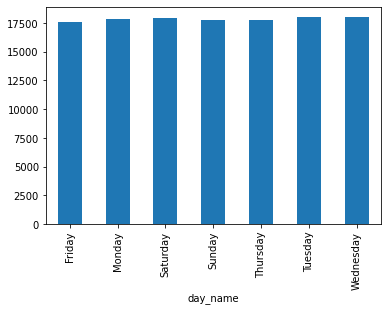

In [33]:
txn.groupby('day_name')['customer_id'].count().plot.bar()
plt.show()

> 3. Following the same logic as in section 1.2, generate the features that capture the count of transactions per client, year and day of the week. The intermediate MultiIndex dataframe (with nlevels=3) and the final pivoted output with a single index are shown
in the snapshots below.

In [45]:
annual_day_of_week_counts = txn.groupby(['customer_id', 'day_name', 'YEAR'])['tran_amount'].count()
annual_day_of_week_counts = pd.DataFrame(annual_day_of_week_counts) 
annual_day_of_week_counts.columns = ['cnt']
annual_day_of_week_counts_pivot = annual_day_of_week_counts.pivot_table(index = 'customer_id',columns=['YEAR','day_name']).fillna(0).astype(int)
annual_day_of_week_counts_pivot.head()

cnt                         ...                                  
YEAR          2011                         ...   2015                           
day_name    Friday Monday Saturday Sunday  ... Sunday Thursday Tuesday Wednesday
customer_id                                ...                                  
CS1112           1      0        0      1  ...      0        0       0         1
CS1113           1      1        0      1  ...      0        0       0         1
CS1114           0      1        0      1  ...      0        1       0         0
CS1115           0      0        1      1  ...      0        1       0         0
CS1116           1      1        0      0  ...      0        0       0         0

[5 rows x 35 columns]

In [46]:
#extract the name of level 0, level 1 and level 2 and convert them to string. Named them level_0 and level_1.
level_0 = annual_day_of_week_counts_pivot.columns.get_level_values(0).astype(str)
level_1 = annual_day_of_week_counts_pivot.columns.get_level_values(1).astype(str)
level_2 = annual_day_of_week_counts_pivot.columns.get_level_values(2).astype(str)
#concatenate level 0, level 1 and level 2 to get the new column name
annual_day_of_week_counts_pivot.columns = level_0 + '_' + level_1 + '_' + level_2
annual_day_of_week_counts_pivot.head()

,cnt_2011_Friday,cnt_2011_Monday,cnt_2011_Saturday,cnt_2011_Sunday,cnt_2011_Thursday,cnt_2011_Tuesday,cnt_2011_Wednesday,cnt_2012_Friday,cnt_2012_Monday,cnt_2012_Saturday,cnt_2012_Sunday,cnt_2012_Thursday,cnt_2012_Tuesday,cnt_2012_Wednesday,cnt_2013_Friday,cnt_2013_Monday,cnt_2013_Saturday,cnt_2013_Sunday,cnt_2013_Thursday,cnt_2013_Tuesday,cnt_2013_Wednesday,cnt_2014_Friday,cnt_2014_Monday,cnt_2014_Saturday,cnt_2014_Sunday,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,1,0,0,1,0,0,1,0,0,1,3,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1
CS1113,1,1,0,1,0,0,0,2,1,0,0,0,1,1,0,1,1,0,0,2,1,0,0,1,0,0,3,0,0,2,0,0,0,0,1
CS1114,0,1,0,1,1,0,2,0,0,1,1,0,0,0,0,1,0,1,2,0,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0
CS1115,0,0,1,1,0,0,1,1,1,0,2,1,1,1,0,1,2,0,2,0,2,0,0,0,0,2,0,2,0,0,0,0,1,0,0
CS1116,1,1,0,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0


> 4. Confirm that your output has the same number of rows as the final output in section 1.2 and save it as **annual_day_of_week_counts_pivot.xlsx.** How many features/columns did you create in this section?



In [50]:
print(f'annual_day_of_week_counts_pivot has {annual_day_of_week_counts_pivot.shape[0]} rows.')
print("annual_day_of_week_counts_pivot has same number of rows as final output in section 1.2:",
       annual_day_of_week_counts_pivot.shape[0] == len(clnt_annual_aggregations_pivot))
print(f"number of features/columns create: {annual_day_of_week_counts_pivot.shape[1]}")
annual_day_of_week_counts_pivot.to_excel('annual_day_of_week_counts_pivot.xlsx')

annual_day_of_week_counts_pivot has 6889 rows.
annual_day_of_week_counts_pivot has same number of rows as final output in section 1.2: True
number of features/columns create: 35
